# КММФЯ, задание 2
## Методические указания по выполнению работы

Использование *матрицы направляющих косинусов* действительно упрощает решение данной системы уравнений, особенно с точки зрения памяти и машинного времени. Однако, этот подход оправдан только в данной в задании формулировке, а именно для поиска решения уравнений вдоль определенного направления. Конечно, существуют такие коммерческие программные пакеты как **Matlab** и **Mathematica** или бесплатные библиотеки для **Python**, поддерживающие символьные вычисления, которые могут позволить автоматизировать процесс нахождения матрицы поворота и её использование. Тогда можно будет находить решение для любого направления. Но в данном разделе мы рассмотрим наиболее общий подход решения системы "в лоб", что позволит получить на выходе многомерную матрицу, из которой можно будет вычленить данные о поведении системы в пределах заданной области на протяжении всего численного эксперимента.

### Конечно-разностные аппроксимации производных

Условимся в обозначениях индексов - в процессе вывода конечно-разностной схемы их получится много. Индекс обозначающий компоненту вектора смещения обозначим вверху $U^\mathrm{x}$, а бугущие - курсивом внизу $U_x$. Запись $U_{r,t}^\mathrm{y}$ обозначает - игрековая компонента вектора смещения в точке с номером r в момент времени с номером t. Один пространсвенный индекс присущ одномерной системе.
Так как данное пособие планируется для студентов имеющих степень бакалавра технической специальности, положим, что идея конечных-разностей Вам хотя бы смутно, но знакома, и поэтому можно не останавливаться на выводе формул, а сразу записать что нам нужно. 
Для уравнения

$$\frac{\partial ^2 U}{\partial t^2} = \frac{1}{a^2}\frac{\partial ^2 U}{\partial r^2}$$

конечно-разностная аппроксимация будет иметь вид:

$$\frac{U_{r,t-1}-2U_{r,t}+U_{r,t+1}}{dt^2} = \frac{U_{r-1,t}-2U_{r,t}+U_{r+1,t}}{a^2 dr^2}$$  

где $dr$ и $dt$ сответственно шаг по координате и шаг по времени. 
Из этой формулы нужно выразить $U_{r,t+1}$ и рассчитав значения в начальном временном слое и на границах, можно найти U на каждом временном отрезке. Такой вид принимают уравнения из первого задания, так как решение нужно найти вдоль одной из координат.

### Программная реализация

Код данного алгоритма на языке **Julia** выполнен в следующей ячейке

In [1]:
# функция задающая начальное условие
function psi(x)
   cos(x) 
end
# поведение на границах
function pfy(x)
   sin(x) 
end
# решение одномерного волнового уравнения
function pdesolver!(u, N, K, L, T, a)
    dr = L/N;
    dt = T/K;
    gam = a*a*dt*dt/dr/dr;
    # инициализируем первые два временных слоя
    for r = 1:N
        u[r,1] = psi(r*dr);
        u[r,2] = u[r,1] + dt*psi(r*dr);
    end
    # задаём поведение на границах
    for t = 1:K
        u[1,t] = 0;
        u[N,t] = pfy(L);
    end
    # теперь у нас массив размером N на K у которого расчетными значениями заполнены
    # две первые строки и первый и последний столбцы, оставшиеся элементы расчитываем
    # используя конечные разности
    for t = 2:K-1
        for r = 2:N-1
            u[r,t+1] = -u[r,t-1] + gam*u[r-1,t] + (2-2*gam)*u[r,t] + gam*u[r+1,t];
        end
    end
end

pdesolver! (generic function with 1 method)

In [4]:
using Plots

Plots.GRBackend()

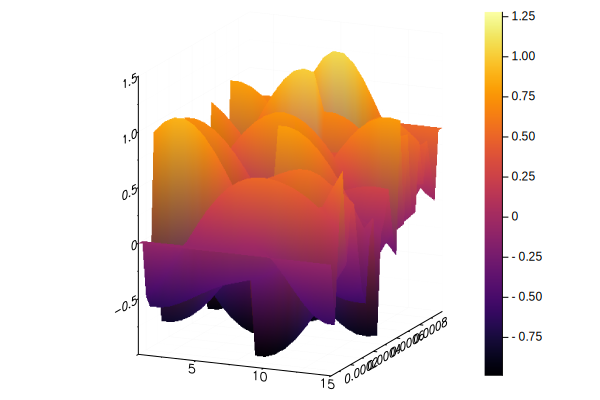

In [5]:
N = 20; # количество шагов по координате
K = 30; # и по времени
a = 5559; # скорость распространения волны (рассчитана из констант данных в задании)
L = 15; # длина образца (в данной формулировке - нити из Fe)
T = 1e-3; # длительность эксперимента
u = zeros(N,K); # матрица в которой будет храниться информация о состоянии нити в каждый момент
pdesolver!(u, N, K, L, T, a) # вызываем расчетную функцию

dt = T/K; t = zeros(K);
dr = L/N; r = zeros(N);

for i = 1:N
    r[i] = i*dr;
end

for i = 1:K
    t[i] = i*dt;
end

surface(r,t,u) # изображаем расчетную поверхность

Данный график отображает поведение компоненты смещения U как функции двух переменных r и t. Из формулировки первого задания следует, что система *УвЧП* сводится к трем независимым волновым уравнениям, для каждого из которых в функцию *pdesolver!()* нужно передавать свой параметр *а*. 

### Обобщение на трехмерный случай

Последовательность действий остается прежней, но с возникновением необходимости апроксимации смешанных производных

$$ \frac{\partial ^2 U}{\partial x\partial y} \rightarrow \frac{U_{x+1,y+1}-U_{x+1,y}-U_{x,y+1}+U_{x,y}}{dxdy} $$

Например, последнее слагаемое первого примера будет иметь вид:

$$\frac{\partial ^2 U^\mathrm{z}}{\partial x\partial z} \rightarrow \frac{U^\mathrm{z}_{x+1,y,z+1,t}-U^\mathrm{z}_{x+1,y,z,t}-U^\mathrm{z}_{x,y,z+1,t}+U^\mathrm{z}_{x,y,z,t}}{dxdz}$$

Таким образом, выразив из каждого уравнения $U^\mathrm{i}_{x,y,z,t+1}$ Вы должны получить систему из трех выражений, которые решаются аналогично с первым заданием.

Вариант реализации функции для выполнения *задания 2*:

In [2]:
function pdesolver3d!(U, N, K, L, T)
    dr = L/N;
    dt = T/K;
    rho = 7800.;
    C11 = 2.41e11; C12 = 1.46e11; C44 = 1.12e11;
    gamma = dt*dt/rho*(rho/dt/dt-C11/dr/dr-2*C44/dr/dr);
    # иниц-я первых двух временных слоёв-кубов
    for i = 1:3
        for x = 1:N
            for y = 1:N
                for z = 1:N
                    U[i,x,y,z,1] = pfy( (x-1)*dr );
                    U[i,x,y,z,2] = U[i,x,y,z,1] + dt*psi( (x-1)*dr );
                end
            end
        end
    end
    # задание граничных условий на всех плоскостях К-2 кубов
    for i = 1:3
        for t = 3:K
            for x = 1:N
                for y = 1:N
                    U[i,x,y,1,t] = 0.2;
                    U[i,x,y,N,t] = pfy(L);
                    U[i,1,x,y,t] = 0.8;
                    U[i,N,x,y,t] = pfy(L);
                    U[i,x,1,y,t] = 0.4;
                    U[i,x,N,y,t] = pfy(L);
                end
            end
        end
    end
    
    for t = 2:K-1
        for x = 2:N-1
            for y = 2:N-1
                for z = 2:N-1
                    # U[1,x,y,z,t+1] = ; подставить выражения для конечных разносей
            
                    # U[2,x,y,z,t+1] = ; да-да, придётся самим ручками на бумаге выводить
            
                    # U[3,x,y,z,t+1] = ;
                end
            end
        end
    end     
end

pdesolver3d! (generic function with 1 method)

Пятимерный массив U посли инициализации этой функцией будет иметь сведения о динамике распространения волн по всему объёму среды. Можно отобразить распространение волны на произвольном срезе в определенный момент: ```surf(U[1,:,:,z=8,time=11],title="Relief",plotstyle="pm3d")```
или построить решения для волн распространяющихся в направлении [111], то есть по диагонали куба, значит нужны диагональные элеметы многомерной матрицы:

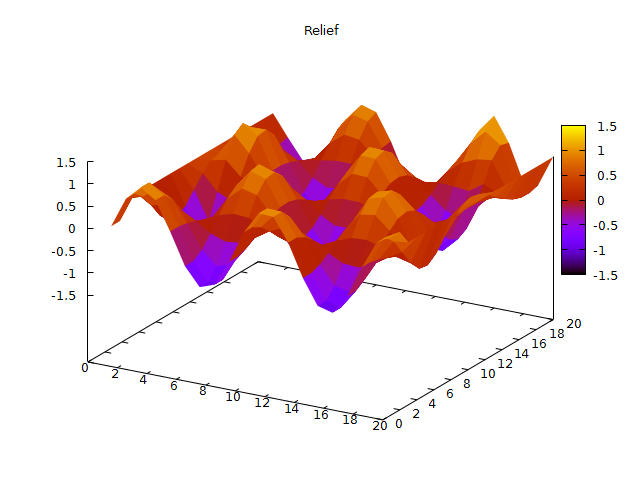

1

In [6]:
U111 = zeros(3,N,K);
for i = 1:3
    for t=1:K
        for r=1:N
            U111[i,r,t] = U[i,r,r,r,t];
        end
    end
end
surf(U111[2,:,:],title="Relief",plotstyle="pm3d")

In [3]:
function psi(x)
   cos(x) 
end

function pfy(x)
   sin(x) 
end

function pdesolver3d!(U, N, K, L, T)
    dr = L/N;
    dt = T/K;
    rho = 7800.;
    C11 = 2.41e11; C12 = 1.46e11; C44 = 1.12e11;
    gamma = dt*dt/rho*(rho/dt/dt-C11/dr/dr-2*C44/dr/dr);
    
#    for x = 1:N
#        r[x] = (x-1)*dr;
#    end
    
    for i = 1:3
        for x = 1:N
            for y = 1:N
                for z = 1:N
                    U[i,x,y,z,1] = pfy( (x-1)*dr );
                    U[i,x,y,z,2] = U[i,x,y,z,1] + dt*psi( (x-1)*dr );
                end
            end
        end
    end
    
#    for t = 1:K
#        cron[t] = (t-1)*dt;
#    end

    for i = 1:3
        for t = 3:K
            for x = 1:N
                for y = 1:N
                    U[i,x,y,1,t] = 0.2;
                    U[i,x,y,N,t] = pfy(L);
                    U[i,1,x,y,t] = 0.8;
                    U[i,N,x,y,t] = pfy(L);
                    U[i,x,1,y,t] = 0.4;
                    U[i,x,N,y,t] = pfy(L);
                end
            end
        end
    end
    
    for t = 2:K-1
        for x = 2:N-1
            for y = 2:N-1
                for z = 2:N-1
                    U[1,x,y,z,t+1] = -U[1,x,y,z,t-1] + U[1,x,y,z,t]*2*gamma + C11*dt*dt/dr/dr/rho*(U[1,x+1,y,z,t]+U[1,x-1,y,z,t])
                    + C44*dt*dt/dr/dr/rho*(U[1,x,y+1,z,t] + U[1,x,y-1,z,t] + U[1,x,y,z+1,t] + U[1,x,y,z-1,t])
                    + (C12+C44)*dt*dt/dr/dr/rho*(U[2,x+1,y+1,z,t] - U[2,x,y+1,z,t] - U[2,x+1,y,z,t] + U[2,x,y,z,t]
                    + U[3,x+1,y,z+1,t] - U[3,x,y,z+1,t] - U[3,x+1,y,z,t] + U[3,x,y,z,t]);
            
                    U[2,x,y,z,t+1] = -U[2,x,y,z,t-1] + U[2,x,y,z,t]*2*gamma + C11*dt*dt/dr/dr/rho*(U[2,x,y+1,z,t]+U[2,x,y-1,z,t])
                    + C44*dt*dt/dr/dr/rho*(U[2,x+1,y,z,t] + U[2,x-1,y,z,t] + U[2,x,y,z+1,t] + U[2,x,y,z-1,t])
                    + (C12+C44)*dt*dt/dr/dr/rho*(U[1,x+1,y+1,z,t] - U[1,x,y+1,z,t] - U[1,x+1,y,z,t] + U[1,x,y,z,t]
                    + U[3,x,y+1,z+1,t] - U[3,x,y,z+1,t] - U[3,x,y+1,z,t] + U[3,x,y,z,t]);
            
                    U[3,x,y,z,t+1] = -U[3,x,y,z,t-1] + U[3,x,y,z,t]*2*gamma + C11*dt*dt/dr/dr/rho*(U[3,x,y,z+1,t]+U[3,x,y,z-1,t])
                    + C44*dt*dt/dr/dr/rho*(U[3,x,y+1,z,t] + U[3,x,y-1,z,t] + U[3,x+1,y,z,t] + U[3,x-1,y,z,t])
                    + (C12+C44)*dt*dt/dr/dr/rho*(U[1,x+1,y,z+1,t] - U[1,x,y,z+1,t] - U[1,x+1,y,z,t] + U[1,x,y,z,t]
                    + U[2,x,y+1,z+1,t] - U[2,x,y,z+1,t] - U[2,x,y+1,z,t] + U[2,x,y,z,t]);
                end
            end
        end
    end     
end
N = 20;
K = 20;
L = 15;
T = 1e-3;
U = zeros(3,N,N,N,K);

pdesolver3d!(U, N, K, L, T)
using Gaston